# Photo 2 Model Project

## Motivation
With the development of the digital age, an abundance of media in a 2D form have arose (writing, images, videos, etc). But as society progresses further into fields of AI and VR, a massive shift will occur from development in 2D environments to development in 3D environments. Therefore more capable hardware and more advanced software will be required (with some even being prototyped already) to meet these demands. However, to bridge the gap and to discover insights for hardware design, is there a means of **utilizing current 2D hardware and software techniques to devise solutions for the 3D realm**?

---

## Goals
* Gather image(s) of an object (from anywhere) and identify its silhouette
* Take these understood images and map it into a model representation
* Translate this model representation into a 3D environment

---

## Technical Challenges
### Computer Vision
#### Image Processing
* Colorspaces - viewing the same image in different colorspaces can allow greater capability of finding gradients
* Perspective transforms - can help to standardize image orientation for more accurate image recognition
* Gradient masks - gradients can vary dramatically with environment discrepancies

#### Machine Learning
* ConvNN to filter out a silhouette - depends on how one plans to use image recognition in this pipeline
* Predicting light source orientations?

#### Calibration (locusts into lines)
* Defining interesting points (2D) - derive from gradients; refine based on image traits (lighting, quality)
* Conversion of locusts into lines (2D) - polynomials 

### Modeling
#### Aligning contours
* Joining lines into 3D space based on reference points 
* Probably needs something more reliable than ConvNN on unknown unknowns. Maybe known reference tags to tape on (or a box frame)
* Recognizing missing/disconnected contours

#### Physics
* TBD

---

## Pipeline
### Setting up images
* Upload a few samples of an image set (for the same object)
* Camera calibration

### Preprocessing
* Colorspaces: RGB, HSV/HLS, YUV/YCbCr, LAB
* Perspective warping: translate, rotate, zoom, perspective
* Equalization and filtering (based on assumptions or known aspects of environment)

### Silhouette detection
* HOG gradients
* Sobel mask
* Refining locusts
* NOTE: can allow user input to potentially improve accuracy of pinpointing object

### Defining Contours
* Identifying reference points (inflection points are likeliest candidates)
* Trying various polynomials (pre-determined set of polynomial orders)
* We can assume that contours must be a closed shape
* NOTE: if using user defined silhouette, there is potential to enhance contour definitions with a Gaussian kernel

### Defining Model
* Identifying reference points (may require ConvNN on HOG features to match points)
* NOTE: this aspect is where a pre-defined reference box frame would help tremendously with consistency. Can maybe even have a virtually defined box that uses camera triaxial accelerometers to retain reference points on phone when taking pictures
* Capturing data and defining at highest possible resolution

### Setting up model
* Convert generated file format into new format
* NOTE: Game environments (Unity, Unreal Engine) and CAD (Solidworks, AutoCAD, etc.)

---

## Milestones and Progress notes
### Identify object silhouette - IN PROGRESS
### Define contour equations (2D) - IN PROGRESS
### Map contours into model (3D) - IN PROGRESS
### Convert into modeling environment - IN PROGRESS


---

In [2]:
# Import libraries
import cv2
import glob
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from PIL import Image
import random
from skimage import color, exposure
import tensorflow as tf
from textwrap import wrap
import time

%matplotlib inline

In [36]:
# Globals - paths, checks, flags, sets
cwd = os.getcwd()
img_Path = cwd + '/image_samples/BrushersWaterBottle/'
img_Set = 'noBack'

img_size = (498, 498, 3)

In [71]:
# Helper functions
#####################################################
#              IMAGE VALUE ADJUSTMENT               #
#####################################################
def convert_color(img, cspace='RGB'):
    if cspace !='RGB':
        if cspace == 'HSV':
            img_out = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            img_out = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            img_out = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            img_out = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            img_out = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        img_out = np.copy(img)
    return img_out

def equalize(img, px):
    hist, bins = np.histogram(img.flatten(), px, normed=True)
    cdf = hist.cumsum()
    cdf = (px-1) * cdf / cdf[-1]
    img_eq = np.interp(img.flatten(), bins[:-1],cdf)
    img = img_eq.reshape(img.shape)
    if 0:
        hsv = color.rgb2hsv(img)
        hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
        img = color.hsv2rgb(hsv)
    return img

# grayscale
def grayscale(img):
    img = np.sum(img/3, axis=2, keepdims=True)
    return img

# normalize
def normalize(img, px):
    img = (img - (px/2)) / (px/2)
    return img

# full pre-processing
def preProcess(images):
    images_out = []
    for img in images:
        img = img.astype('float32')
        img = grayscale(img)
        img = equalize(img)
        img = normalize(img)
        images_out.append(img)
    images_out = np.asarray(images_out)    
    return images_out

#####################################################
#               IMAGE TRANSFORMATIONS               #
#####################################################
# affine
def img_affine(img, warp=0.05):
    rows,cols,_ = img.shape
    # determine starting points
    x1 = cols/4
    x2 = cols*3/4
    y1 = rows/4
    y2 = rows*3/4
    # randomize delta
    dx = np.random.rand(3) - 0.5
    dx *= cols * warp
    dy = np.random.rand(3) - 0.5
    dy *= rows*warp
    # set start and end points
    pts1 = np.float32([[y1,x1],[y2,x1],[y1,x2]])
    pts2 = np.float32([[y1+ dy[0],x1+ dx[0]],[y2+ dy[1],x1+ dx[1]],[y1+ dy[2],x2+ dx[2]]])
    # perform transform
    M = cv2.getAffineTransform(pts1,pts2)
    dst = cv2.warpAffine(img,M,(cols,rows))
    dst = dst[:,:,np.newaxis]
    return dst

# brightness
def img_bright(img, light=0):
    shifted = img + 1.0   # shift to (0,2) range
    img_max_value = max(shifted.flatten())
    max_coef = 2.0/img_max_value
    min_coef = max_coef - 0.1
    coef = np.random.uniform(min_coef, max_coef)
    dst = shifted * coef - 1.0
    return dst

# rotate
def img_rotate(img, theta=0):
    rows, cols,_ = img.shape
    # determine matrix and perform warp
    M = cv2.getRotationMatrix2D((cols/2, rows/2), theta, 1)
    dst = cv2.warpAffine(img, M, (cols,rows))
    dst = dst[:,:,np.newaxis]
    return dst

# scale
def img_scale(img, rho=1):
    rows, cols,_ = img.shape
    # generate a rho value for scaling
    if rho==0 or rho==1:
        rho = random.uniform(0.5, 1.5)
    # perform rotation
    M = cv2.getRotationMatrix2D((cols/2,rows/2),0,rho)
    dst = cv2.warpAffine(img,M,(cols,rows))
    dst = dst[:,:,np.newaxis]
    return dst

# translate
def img_translate(img, dist=0):
    rows, cols,_ = img.shape
    # generate delta distances for x and y
    dx = random.randint(-1,1)*dist
    dy = random.randint(-1,1)*dist
    # perform translation
    M = np.float32([[1,0,dx],[0,1,dy]])
    dst = cv2.warpAffine(img,M,(cols,rows))
    dst = dst[:,:,np.newaxis]
    return dst

In [62]:
# Load the images
images = []

for filename in glob.glob(img_Path + img_Set + '*.jpg'):
    im = Image.open(filename)
    im = im.convert('RGB')
    im = im.resize(img_size[:2], Image.ANTIALIAS)
    im = np.array(list(im.getdata()), dtype='uint8')
    im = np.reshape(im, img_size)
    images.append(im)
    
images = np.asarray(images)
print("shape of images: {}".format(images.shape[1:]))
print("number of images: {}".format(images.shape[0]))

shape of images: (498, 498, 3)
number of images: 6


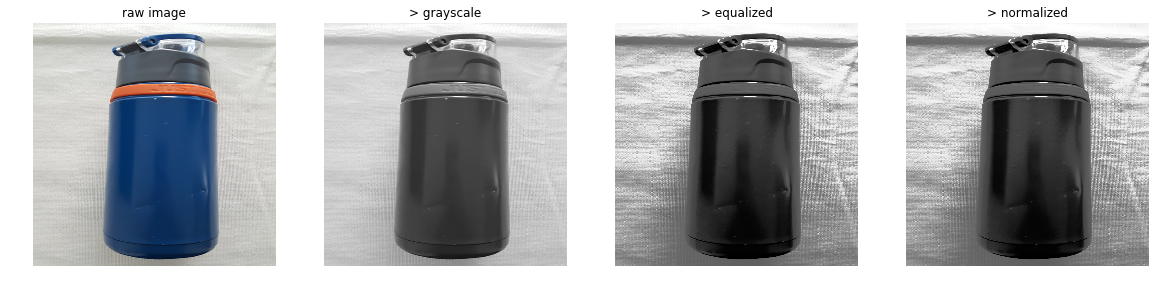

In [70]:
# Visualize processing steps on a single image
test_img = images[0]
test_imgRotated = img_rotate(test_img, -90)

# Visualize 
test_imgGray = grayscale(test_img)
test_imgGray = img_rotate(test_imgGray, -90)
test_imgEq = equalize(test_imgGray, img_size[0])
test_imgNorm = normalize(test_imgEq, img_size[0])
fig, axs = plt.subplots(1,4, figsize =(20, 20))
axs[0].axis('off')
axs[0].imshow(test_imgRotated.squeeze(), cmap='gray')
axs[0].set_title('raw image')
axs[1].axis('off')
axs[1].imshow(test_imgGray.squeeze(), cmap='gray')
axs[1].set_title('> grayscale')
axs[2].axis('off')
axs[2].imshow(test_imgEq.squeeze(), cmap='gray')
axs[2].set_title('> equalized')
axs[3].axis('off')
axs[3].imshow(test_imgNorm.squeeze(), cmap='gray')
axs[3].set_title('> normalized')



In [ ]:
# Visualize colorspaces


In [ ]:
# Display image set
fig, axs = plt.subplots(2, int(images.shape[0]/2), figsize=(16, 9))
fig.subplots_adjust(hspace = 0.1, wspace = 0.1)
axs = axs.ravel()

for i, image in enumerate(images):
    axs[i].axis('off')
    axs[i].imshow(image, cmap='gray')
    